<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Training an Object Detection Model

In this notebook, we give an introduction to training an object detection model using [torchvision](https://pytorch.org/docs/stable/torchvision/index.html). Using a small dataset, we demonstrate how to train and evaluate a FasterRCNN object detection model. We also cover one of the most common ways to store data on a file system for this type of problem.

To learn more about how object detection work, visit our [FAQ](../FAQ.md).

## Initialization

In [9]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Import all the functions we need.

In [3]:
import sys

sys.path.append("../../")

import os
import time
import matplotlib.pyplot as plt
from typing import Iterator
from pathlib import Path
from PIL import Image
from random import randrange
from typing import Tuple
import torch
from torchvision import transforms
import scrapbook as sb

from utils_cv.common.data import unzip_url, data_path
from utils_cv.detection.data import Urls
from utils_cv.detection.dataset import DetectionDataset
from utils_cv.detection.plot import (
    display_bounding_boxes,
    plot_grid,
    plot_boxes,
    plot_pr_curves,
    PlotSettings,
    plot_detection_vs_ground_truth,
)
from utils_cv.detection.model import DetectionLearner, _get_det_bboxes
from utils_cv.common.gpu import which_processor

which_processor()

Torch is using GPU: Tesla V100-PCIE-16GB


This shows your machine's GPUs (if has any) and the computing device `torch/torchvision` is using.

Next, set some model runtime parameters. We use the `unzip_url` helper function to download and unzip the data used in this example notebook.

In [4]:
DATA_PATH = unzip_url(Urls.fridge_objects_path, exist_ok=True)
EPOCHS = 8
LEARNING_RATE = 0.005

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

---

# Prepare Object Detection Dataset

In this notebook, we use a toy dataset called *Fridge Objects*, which consists of 134 images of 4 classes of beverage container `{can, carton, milk bottle, water bottle}` photos taken on different backgrounds. The helper function downloads and unzips data set to the `ComputerVision/data` directory.

Set that directory in the `path` variable for ease of use throughout the notebook.

In [5]:
path = Path(DATA_PATH)
os.listdir(path)

['.DS_Store', 'annotations', 'images']

You'll notice that we have two different folders inside:
- `/images`
- `/annotations`

This format for object detection is fairly common.

```
/data
+-- images
|   +-- image1.jpg
|   +-- image2.jpg
|   +-- ...
+-- annotations
|   +-- image1.xml
|   +-- image2.xml
|   +-- ...
+-- ...
```

Each image corresponds to an xml file. Each xml file contains information on where its corresponding image file is located. It also contains information about the bounding boxes and the object labels. In this example, our fridge object dataset is annotated in Pascal VOC format. This is one of the most common formats for labelling object detection datasets.

```xml
<!-- Example Pascal VOC annotation -->
<annotation>
    <folder>images</folder>
    <filename>1.jpg</filename>
    <path>../images/1.jpg</path>
    <source>
        <database>Unknown</database>
    </source>
    <size>
        <width>499</width>
        <height>666</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>

    <object>
        <name>carton</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <difficult>0</difficult>
        <bndbox>
            <xmin>100</xmin>
            <ymin>173</ymin>
            <xmax>233</xmax>
            <ymax>521</ymax>
        </bndbox>
    </object>
</annotation>
```

You'll notice that inside the annotation xml file, we can see which image the file references `<path>`, the number of `<objects>` in the image, that the image is of (`<name>`) and the bounding box of that object (`<bndbox>`).

# Load Images

To load the data, we need to create a Dataset object class that Torchvision knows how to use. In short, we'll need to create a class and implement the `__getitem__` method. More information here: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html#defining-the-dataset

To make it more convinient, we've created a `DetectionDataset` class that knows how to extract annotation information from the Pascal VOC format and meet the requirements of the Torchvision dataset object class. 

In [6]:
data = DetectionDataset(DATA_PATH, train_pct=0.7)

Inspect our Datasets/DataLoaders to make sure the train/test split looks right.

In [7]:
print(
    f"Training dataset: {len(data.train_ds)} | Training DataLoader: {data.train_dl} \nTesting dataset: {len(data.test_ds)} | Testing DataLoader: {data.test_dl}"
)

Training dataset: 90 | Training DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7ff55f4f6dd8> 
Testing dataset: 38 | Testing DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7ff55f4f6cf8>


Lets visualize some of the images to make sure the annotation looks correct.

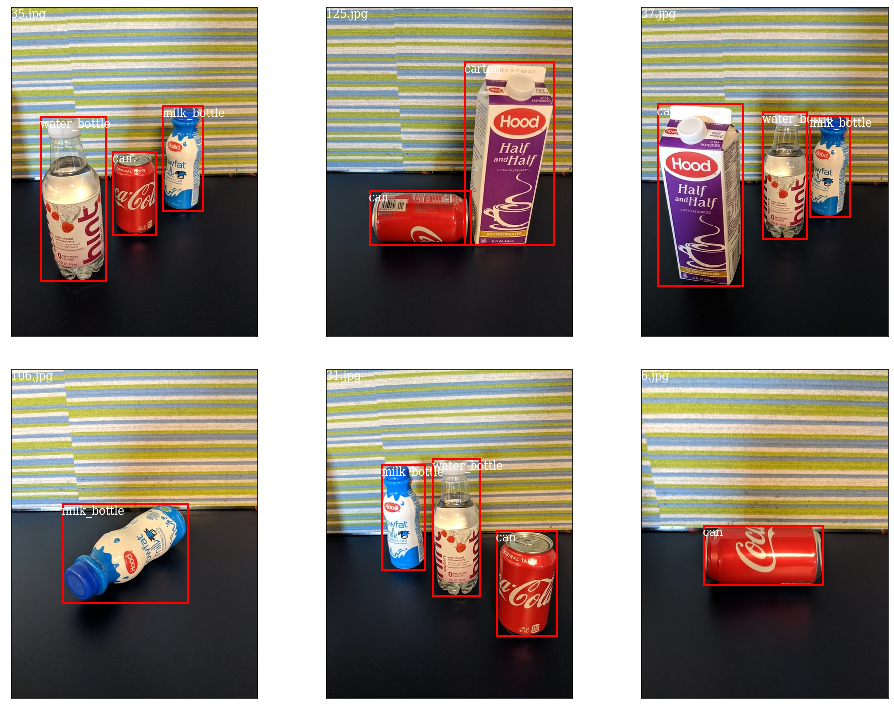

In [10]:
data.show_ims(rows=2, rand=True)

# Finetune a Pretrained Model

For the DetectionLearner, we use Faster R-CNN as the default model, and Stochastic Gradient Descent as our default optimizer. 

Our Faster R-CNN model is pretrained on COCO, a large-scale object detection, segmentation, and captioning dataset that contains over 200K labeled images with over 80 label cateogories.

When we initialize the DetectionLearner, the object will set the model to torchvision's Faster R-CNN.

In [11]:
detector = DetectionLearner(data)

Lets also check that our model is properly set.

In [12]:
print(f"Model: {type(detector.model)}")

Model: <class 'torchvision.models.detection.faster_rcnn.FasterRCNN'>


Fine-tune the model using our training data loader (`train_dl`) and evaluate our results using our testing data loader (`test_dl`). Here we pass in the learning rate. If not set, the learning rate will automatically be set at 0.005.

In [14]:
detector.fit(EPOCHS, lr=LEARNING_RATE, print_freq=30)

Epoch: [0]  [ 0/45]  eta: 0:00:55  lr: 0.000119  loss: 1.7194 (1.7194)  loss_classifier: 1.4598 (1.4598)  loss_box_reg: 0.2474 (0.2474)  loss_objectness: 0.0009 (0.0009)  loss_rpn_box_reg: 0.0113 (0.0113)  time: 1.2246  data: 0.2364  max mem: 2924
Epoch: [0]  [30/45]  eta: 0:00:03  lr: 0.003524  loss: 0.4989 (0.7156)  loss_classifier: 0.2616 (0.4776)  loss_box_reg: 0.2180 (0.2240)  loss_objectness: 0.0009 (0.0050)  loss_rpn_box_reg: 0.0072 (0.0089)  time: 0.1980  data: 0.0064  max mem: 3534
Epoch: [0]  [44/45]  eta: 0:00:00  lr: 0.005000  loss: 0.3558 (0.6073)  loss_classifier: 0.1760 (0.3853)  loss_box_reg: 0.1785 (0.2083)  loss_objectness: 0.0005 (0.0040)  loss_rpn_box_reg: 0.0109 (0.0096)  time: 0.2006  data: 0.0064  max mem: 3534
Epoch: [0] Total time: 0:00:09 (0.2219 s / it)
creating index...
index created!
Test:  [ 0/45]  eta: 0:00:14  model_time: 0.1019 (0.1019)  evaluator_time: 0.0060 (0.0060)  time: 0.3210  data: 0.2105  max mem: 3534
Test:  [44/45]  eta: 0:00:00  model_time: 

Epoch: [4]  [ 0/45]  eta: 0:00:18  lr: 0.000500  loss: 0.0505 (0.0505)  loss_classifier: 0.0346 (0.0346)  loss_box_reg: 0.0119 (0.0119)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0039 (0.0039)  time: 0.4190  data: 0.2138  max mem: 3540
Epoch: [4]  [30/45]  eta: 0:00:03  lr: 0.000500  loss: 0.0621 (0.0669)  loss_classifier: 0.0441 (0.0471)  loss_box_reg: 0.0122 (0.0138)  loss_objectness: 0.0002 (0.0012)  loss_rpn_box_reg: 0.0039 (0.0048)  time: 0.1991  data: 0.0075  max mem: 3540
Epoch: [4]  [44/45]  eta: 0:00:00  lr: 0.000500  loss: 0.0659 (0.0660)  loss_classifier: 0.0441 (0.0476)  loss_box_reg: 0.0098 (0.0128)  loss_objectness: 0.0001 (0.0009)  loss_rpn_box_reg: 0.0043 (0.0047)  time: 0.1997  data: 0.0074  max mem: 3541
Epoch: [4] Total time: 0:00:09 (0.2045 s / it)
creating index...
index created!
Test:  [ 0/45]  eta: 0:00:15  model_time: 0.0798 (0.0798)  evaluator_time: 0.0058 (0.0058)  time: 0.3359  data: 0.2477  max mem: 3541
Test:  [44/45]  eta: 0:00:00  model_time: 

Visualize the loss and average precision (ap) over time.

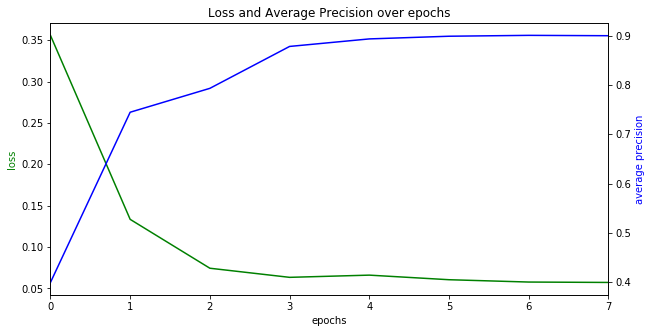

In [15]:
detector.plot_precision_loss_curves()

# Evaluate

We can simply run the `evaluate()` method on our detector to evaluate the results.

Below, you'll notice the notation IoU=0.5:0.95 in the results above. This means: the average mAP over different IoU thresholds, from 0.5 to 0.95, at step size of 0.05 (0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95). For more information on IoU and mAP, visit our [FAQ](../FAQ.md).

In [16]:
e = detector.evaluate()

creating index...
index created!
Test:  [ 0/19]  eta: 0:00:05  model_time: 0.0867 (0.0867)  evaluator_time: 0.0046 (0.0046)  time: 0.3112  data: 0.2175  max mem: 3542
Test:  [18/19]  eta: 0:00:00  model_time: 0.0734 (0.0744)  evaluator_time: 0.0046 (0.0047)  time: 0.0970  data: 0.0159  max mem: 3542
Test: Total time: 0:00:01 (0.0990 s / it)
Averaged stats: model_time: 0.0734 (0.0744)  evaluator_time: 0.0046 (0.0047)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.884
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.884
 Average Recall     (AR) @[ Io

Plot precision-recall curves. We'll use the `plot_pr_curves` function to plot the PR of each IoU threshold, and also the average over the IoU thresholds. If we look at the graph on the left, we can see that the lower the IOU threshold, the higher better the results are for the PR curve. This makes sense as the model is more lenient. This is why it is also a good idea to take a look at the mean over the IOU thresholds.

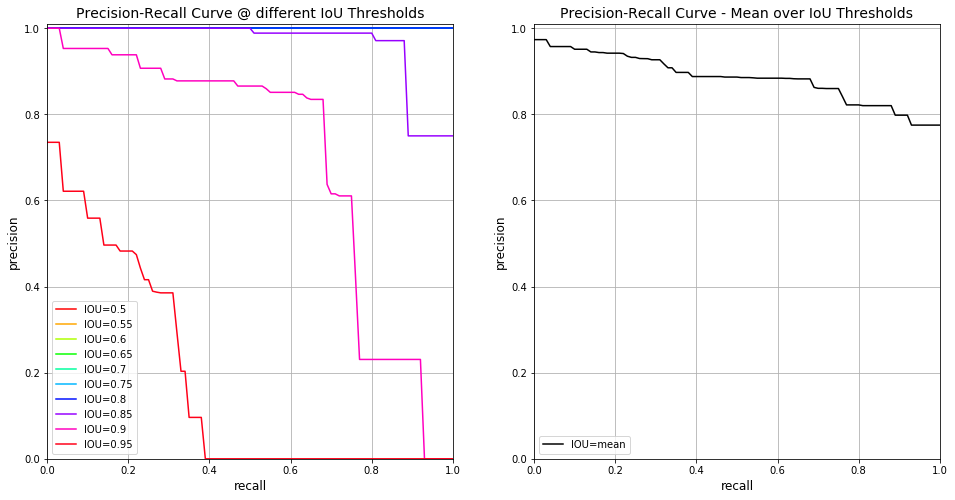

In [17]:
plot_pr_curves(e)

# Predict Batches

We can predict a group of images using the `predict_dl` function. We pass it a dataloader that references the images we want to predict and it will perform the predictions by the batch size specified when constructing the dataloader. In this case, we'll just use the test DataLoader (`test_dl`) that we created above. This dataloader uses the batch size set by the parameter `BATCH_SIZE`. 

In [63]:
detections = detector.predict_dl(data.test_dl, threshold=0.6)

5
[{Bbox object: [left=38, top=201, right=185, bottom=486] | <carton> | label:4 | path:/home/jiata/code/cvbp/data/odFridgeObjects/annotations/64.xml} | score: 0.999431312084198, {Bbox object: [left=289, top=318, right=376, bottom=475] | <can> | label:2 | path:/home/jiata/code/cvbp/data/odFridgeObjects/annotations/64.xml} | score: 0.9989263415336609, {Bbox object: [left=179, top=261, right=264, bottom=477] | <milk_bottle> | label:1 | path:/home/jiata/code/cvbp/data/odFridgeObjects/annotations/64.xml} | score: 0.9966729879379272, {Bbox object: [left=368, top=223, right=468, bottom=471] | <water_bottle> | label:3 | path:/home/jiata/code/cvbp/data/odFridgeObjects/annotations/64.xml} | score: 0.9951874017715454]
4
6
[{Bbox object: [left=25, top=334, right=125, bottom=499] | <can> | label:2 | path:/home/jiata/code/cvbp/data/odFridgeObjects/annotations/81.xml} | score: 0.998963475227356, {Bbox object: [left=342, top=222, right=487, bottom=510] | <carton> | label:4 | path:/home/jiata/code/cvbp

7
[{Bbox object: [left=348, top=331, right=455, bottom=515] | <can> | label:2 | path:/home/jiata/code/cvbp/data/odFridgeObjects/annotations/56.xml} | score: 0.9995279312133789, {Bbox object: [left=21, top=253, right=135, bottom=509] | <milk_bottle> | label:1 | path:/home/jiata/code/cvbp/data/odFridgeObjects/annotations/56.xml} | score: 0.9992176294326782, {Bbox object: [left=162, top=167, right=319, bottom=535] | <carton> | label:4 | path:/home/jiata/code/cvbp/data/odFridgeObjects/annotations/56.xml} | score: 0.9986621141433716]
3
22
[{Bbox object: [left=83, top=327, right=433, bottom=551] | <carton> | label:4 | path:/home/jiata/code/cvbp/data/odFridgeObjects/annotations/113.xml} | score: 0.9970355033874512, {Bbox object: [left=81, top=138, right=192, bottom=377] | <water_bottle> | label:3 | path:/home/jiata/code/cvbp/data/odFridgeObjects/annotations/113.xml} | score: 0.9960964322090149]
2
15
[{Bbox object: [left=208, top=340, right=471, bottom=608] | <carton> | label:4 | path:/home/ji

5
[{Bbox object: [left=26, top=331, right=280, bottom=581] | <carton> | label:4 | path:/home/jiata/code/cvbp/data/odFridgeObjects/annotations/40.xml} | score: 0.9980573058128357, {Bbox object: [left=245, top=217, right=324, bottom=425] | <milk_bottle> | label:1 | path:/home/jiata/code/cvbp/data/odFridgeObjects/annotations/40.xml} | score: 0.9978916049003601, {Bbox object: [left=344, top=170, right=431, bottom=385] | <water_bottle> | label:3 | path:/home/jiata/code/cvbp/data/odFridgeObjects/annotations/40.xml} | score: 0.9931991696357727]
3
11
[{Bbox object: [left=66, top=268, right=184, bottom=543] | <milk_bottle> | label:1 | path:/home/jiata/code/cvbp/data/odFridgeObjects/annotations/42.xml} | score: 0.998683512210846, {Bbox object: [left=154, top=309, right=396, bottom=512] | <carton> | label:4 | path:/home/jiata/code/cvbp/data/odFridgeObjects/annotations/42.xml} | score: 0.9972158670425415, {Bbox object: [left=338, top=171, right=427, bottom=402] | <water_bottle> | label:3 | path:/h

The `predict_dl` function returns a list of AnnotationBboxes. Lets print out 5 of the detection values.

In [64]:
detections[:5]

[{'idx': 89,
  'det_bboxes': [{Bbox object: [left=38, top=201, right=185, bottom=486] | <carton> | label:4 | path:/home/jiata/code/cvbp/data/odFridgeObjects/annotations/64.xml} | score: 0.999431312084198,
   {Bbox object: [left=289, top=318, right=376, bottom=475] | <can> | label:2 | path:/home/jiata/code/cvbp/data/odFridgeObjects/annotations/64.xml} | score: 0.9989263415336609,
   {Bbox object: [left=179, top=261, right=264, bottom=477] | <milk_bottle> | label:1 | path:/home/jiata/code/cvbp/data/odFridgeObjects/annotations/64.xml} | score: 0.9966729879379272,
   {Bbox object: [left=368, top=223, right=468, bottom=471] | <water_bottle> | label:3 | path:/home/jiata/code/cvbp/data/odFridgeObjects/annotations/64.xml} | score: 0.9951874017715454]},
 {'idx': 108,
  'det_bboxes': [{Bbox object: [left=25, top=334, right=125, bottom=499] | <can> | label:2 | path:/home/jiata/code/cvbp/data/odFridgeObjects/annotations/81.xml} | score: 0.998963475227356,
   {Bbox object: [left=342, top=222, right

We can also verify that the length of the returned detections equal the number of total images in the dataloader.

In [65]:
print(f"Number of detections: {len(detections)}\nImages in the dataloader (Number of batches * batch_size): {len(data.test_dl) * data.test_dl.batch_size}")

Number of detections: 38
Images in the dataloader (Number of batches * batch_size): 38


> __Using a Generator Instead__
>
> Alternatively, we can use the `predict_batch` function if we'd rather get a generator object instead of _all_ the predictions back in one go. This may be preferable if the dataloader you are passing in contains many images and you don't want overflow your machine's memory.
```python
detector_generator = detector.predict_batch(<dataloader>)
one_batch_of_predictions = next(detector_generator)
```


We now have our predictions on the different images from our test set. Since the data is from the test set, we also know what the ground truth bounding boxes for those images are too. Lets plot the ground truth vs predictions for the images. 

To plot the predictions, we'll create a simple function (`get_im_and_bboxes()`) to create a generator that returns the data needed to plot the ground truths vs the detections. This generator returns a new image path (`im_path`), ground truth bounding boxes (`gt_bboxes`), and detection bounding boxes (`det_bboxes`) each time it is iterated on.

Since these are the parameters that the `plot_detection_vs_ground_truth()` function takes, we can pass the entire iterator object to the `plot_grid()` function. For each plot it produces, it will use a new iteration from the generator.

The red boxes represents the ground truth while the green represents the predected bounding box.

In [66]:
def get_im_and_bboxes() -> Iterator:
    for detection in detections:
        det_bboxes = detection["det_bboxes"]
        gt_bboxes, im_path = data._read_anno_idx(detection["idx"])
        yield im_path, gt_bboxes, det_bboxes

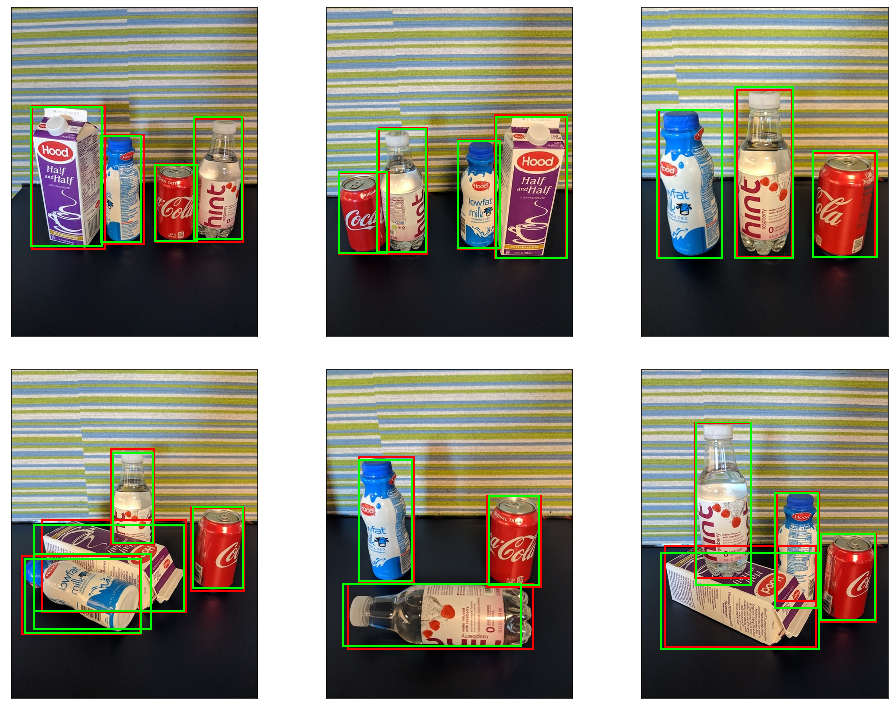

In [67]:
plot_grid(plot_detection_vs_ground_truth, get_im_and_bboxes(), rows=2)

# Predict Single Image

We can use the detector to predict new images. Start by getting a new image. In this case, we'll reuse a random image in our dataset and pretend it is a new image.

In [45]:
new_im_path = data.root / data.im_dir / data.im_paths[randrange(len(data))]
new_im_path

PosixPath('/home/jiata/code/cvbp/data/odFridgeObjects/images/38.jpg')

We can use the inference function:

In [46]:
new_im = Image.open(new_im_path)
preds = detector.predict(new_im, threshold=None)

Now that we have our predictions, lets plot the predictions on our image.

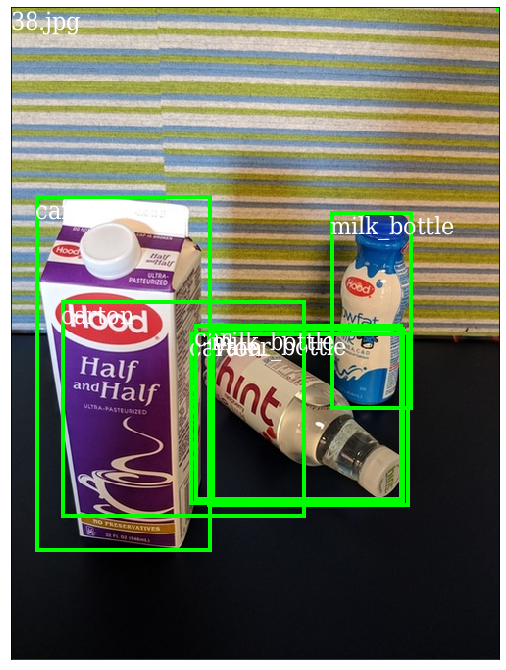

In [47]:
plot_settings = PlotSettings(rect_color=(0, 255, 0))

display_bounding_boxes(
    preds,
    new_im_path,
    plot_settings=plot_settings,
)

---

In [34]:
# Preserve some of the notebook outputs
sb.glue("training_losses", detector.losses)
sb.glue("training_average_precision", detector.ap)

# Conclusion

Using the concepts introduced in this notebook, you can bring your own dataset and train an object detector to find objects of interest in a given image. 

In [36]:
new_im = Image.open(new_im_path)
type(new_im)

PIL.Image.Image